In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from scipy.stats import linregress
from tqdm import tqdm
from Bio import SeqIO
from matplotlib import pyplot as plt
from os import path
from seq_util import *

In [2]:
# Read the NOSC values for bac120 as a wide-form matrix
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Trim the ".1" from the end of the accession numbers so they match other GTDB data
trimmed_ids = [x.split('.')[0] for x in bac120_nosc_df.index.tolist()]
bac120_nosc_df['trimmed_accession'] = trimmed_ids

# Reset the index to the trimmed accession number
bac120_nosc_df = bac120_nosc_df.reset_index().set_index('trimmed_accession')
bac120_nosc_df.head()

,accession,PF00380.20,PF00410.20,PF00466.21,PF01025.20,PF02576.18,PF03726.15,TIGR00006,TIGR00019,TIGR00020,...,TIGR02432,TIGR02729,TIGR03263,TIGR03594,TIGR03625,TIGR03632,TIGR03654,TIGR03723,TIGR03725,TIGR03953
trimmed_accession,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000007325,GB_GCA_000007325.1,-0.148160,-0.224515,-0.271998,-0.122832,-0.222500,-0.195491,-0.189573,-0.152311,-0.116115,...,-0.239489,-0.215168,-0.138229,-0.214850,-0.219437,-0.161122,-0.178828,-0.207375,-0.232777,-0.213205
GB_GCA_000008885,GB_GCA_000008885.1,-0.225820,-0.247991,-0.235449,-0.223839,NaN,-0.212832,-0.275949,-0.212414,-0.160727,...,-0.280723,-0.219518,-0.278769,-0.307224,-0.212944,-0.103641,-0.312473,-0.254505,NaN,-0.265804
GB_GCA_000009845,GB_GCA_000009845.1,-0.210141,-0.304301,-0.323290,-0.130158,NaN,NaN,-0.202842,-0.193418,-0.160336,...,-0.243972,-0.205122,-0.180596,-0.214562,-0.172616,-0.165642,-0.229449,-0.217595,-0.288547,-0.173903
GB_GCA_000010085,GB_GCA_000010085.1,-0.097661,-0.237436,-0.161992,-0.060054,-0.167924,-0.131780,-0.111915,-0.063734,-0.064409,...,-0.078462,-0.093497,-0.132986,-0.143900,-0.152612,-0.093533,-0.164809,-0.124286,-0.153650,-0.178778
GB_GCA_000010565,GB_GCA_000010565.1,-0.187030,-0.251788,-0.224343,-0.079801,-0.200000,-0.177482,-0.149577,-0.113914,-0.096177,...,-0.179268,-0.101351,-0.181850,-0.177694,-0.190099,-0.100300,-0.222171,-0.170978,-0.203634,-0.148263


In [3]:
# Read the annotated bac120 metadata
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Read the genome average NOSC values for representative genomes
reps_genome_nosc_df = pd.read_csv('../data/gtdb/r207/genome_average_nosc.csv', index_col=0)
reps_genome_nosc_df.head()

,genome_avg_NOSC
genome_accession,
RS_GCF_000971475,-0.159401
RS_GCF_003693265,-0.119059
GB_GCA_018969935,-0.152630
GB_GCA_016790845,-0.158100
GB_GCA_900321855,-0.175164


In [4]:
# Merge the genome average values into the bac120 nosc dataframe
bac120_nosc_df = bac120_nosc_df.merge(reps_genome_nosc_df, left_index=True, right_index=True)
bac120_nosc_df.head()

,accession,PF00380.20,PF00410.20,PF00466.21,PF01025.20,PF02576.18,PF03726.15,TIGR00006,TIGR00019,TIGR00020,...,TIGR02729,TIGR03263,TIGR03594,TIGR03625,TIGR03632,TIGR03654,TIGR03723,TIGR03725,TIGR03953,genome_avg_NOSC
GB_GCA_000007325,GB_GCA_000007325.1,-0.148160,-0.224515,-0.271998,-0.122832,-0.222500,-0.195491,-0.189573,-0.152311,-0.116115,...,-0.215168,-0.138229,-0.214850,-0.219437,-0.161122,-0.178828,-0.207375,-0.232777,-0.213205,-0.223900
GB_GCA_000008885,GB_GCA_000008885.1,-0.225820,-0.247991,-0.235449,-0.223839,NaN,-0.212832,-0.275949,-0.212414,-0.160727,...,-0.219518,-0.278769,-0.307224,-0.212944,-0.103641,-0.312473,-0.254505,NaN,-0.265804,-0.258189
GB_GCA_000009845,GB_GCA_000009845.1,-0.210141,-0.304301,-0.323290,-0.130158,NaN,NaN,-0.202842,-0.193418,-0.160336,...,-0.205122,-0.180596,-0.214562,-0.172616,-0.165642,-0.229449,-0.217595,-0.288547,-0.173903,-0.225228
GB_GCA_000010085,GB_GCA_000010085.1,-0.097661,-0.237436,-0.161992,-0.060054,-0.167924,-0.131780,-0.111915,-0.063734,-0.064409,...,-0.093497,-0.132986,-0.143900,-0.152612,-0.093533,-0.164809,-0.124286,-0.153650,-0.178778,-0.147696
GB_GCA_000010565,GB_GCA_000010565.1,-0.187030,-0.251788,-0.224343,-0.079801,-0.200000,-0.177482,-0.149577,-0.113914,-0.096177,...,-0.101351,-0.181850,-0.177694,-0.190099,-0.100300,-0.222171,-0.170978,-0.203634,-0.148263,-0.179736


In [5]:
# Count up the categories among the bac120
cat_counts = bac120_meta_df.COG.value_counts()

# Add descriptive annotations
cog_df = pd.read_csv('../data/COG-fun-20.csv', index_col=0)
descs = cog_df.loc[cat_counts.index].description
cat_counts = pd.DataFrame(
    dict(count=cat_counts, description=descs))
cat_counts

,count,description
J,70,"Translation, ribosomal structure and biogenesis"
L,18,"Replication, recombination and repair"
K,6,Transcription
U,6,"Intracellular trafficking, secretion, and vesi..."
F,5,Nucleotide transport and metabolism
O,5,"Posttranslational modification, protein turnov..."
H,3,Coenzyme transport and metabolism
M,3,Cell wall/membrane/envelope biogenesis
C,2,Energy production and conversion
D,1,"Cell cycle control, cell division, chromosome ..."


In [6]:
# last column is genome_avg_NOSC -- 
# calculate the pairwise correlations of columns except GC
pairwise_cols = bac120_nosc_df.columns[:-1]
nosc_corr = pg.pairwise_corr(
    bac120_nosc_df, columns=pairwise_cols,
    padjust='fdr_bh')

# Now calculate the partial correlations, controlling for genome_avg_NOSC
nosc_corr_controlled = pg.pairwise_corr(
    bac120_nosc_df, columns=pairwise_cols, covar='genome_avg_NOSC',
    padjust='fdr_bh')

In [7]:
f = lambda row: ','.join(sorted(row))
def _save_corr_df(corr_df, fname):
    # Add descriptions of the two columns
    corr_df['X_desc'] = bac120_meta_df.loc[corr_df.X].Description.values
    corr_df['Y_desc'] = bac120_meta_df.loc[corr_df.Y].Description.values

    # Add COG categories of the two cols
    corr_df['X_COG'] = bac120_meta_df.loc[corr_df.X].COG.values
    corr_df['Y_COG'] = bac120_meta_df.loc[corr_df.Y].COG.values

    # Order-independent COG-pair by sorting the high-level COG-categories
    
    corr_df['COG_pair'] = list(map(f, corr_df['X_COG,Y_COG'.split(',')].values))
    
    # Save
    corr_df.to_csv(fname, index=False)

    
my_fname = '../data/gtdb/r207/bac120_nosc_corr.csv'
_save_corr_df(nosc_corr, my_fname)

my_fname = '../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv'
_save_corr_df(nosc_corr_controlled, my_fname)

In [8]:
nosc_corr_controlled.sort_values('r', ascending=False).head(5)

,X,Y,method,covar,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,X_desc,Y_desc,X_COG,Y_COG,COG_pair
6992,TIGR02013,TIGR02386,pearson,['genome_avg_NOSC'],two-sided,48253,0.515868,"[0.51, 0.52]",0.0,0.0,fdr_bh,"DNA-directed RNA polymerase, beta subunit","DNA-directed RNA polymerase, beta' subunit",K,K,"K,K"
3739,TIGR00392,TIGR00414,pearson,['genome_avg_NOSC'],two-sided,50744,0.500300,"[0.49, 0.51]",0.0,0.0,fdr_bh,isoleucine--tRNA ligase,serine--tRNA ligase,J,J,"J,J"
6399,TIGR01059,TIGR01063,pearson,['genome_avg_NOSC'],two-sided,47364,0.492156,"[0.49, 0.5]",0.0,0.0,fdr_bh,"DNA gyrase, B subunit","DNA gyrase, A subunit",L,L,"L,L"
3487,TIGR00344,TIGR00392,pearson,['genome_avg_NOSC'],two-sided,51309,0.488678,"[0.48, 0.5]",0.0,0.0,fdr_bh,alanine--tRNA ligase,isoleucine--tRNA ligase,J,J,"J,J"
3747,TIGR00392,TIGR00456,pearson,['genome_avg_NOSC'],two-sided,50441,0.485915,"[0.48, 0.49]",0.0,0.0,fdr_bh,isoleucine--tRNA ligase,arginine--tRNA ligase,J,J,"J,J"


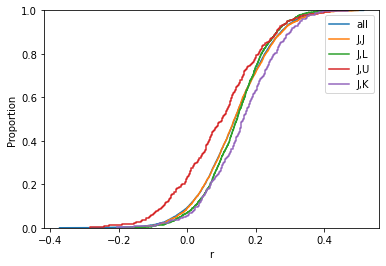

In [9]:
pal = sns.color_palette()
pair_counts = nosc_corr_controlled.COG_pair.value_counts()

sns.ecdfplot(data=nosc_corr_controlled, x='r', label='all')

for pair in pair_counts[:4].index:
    mask = nosc_corr_controlled.COG_pair == pair
    sns.ecdfplot(data=nosc_corr_controlled[mask], x='r', label=pair)

plt.legend()
plt.show()

plotting 7140 of 7140


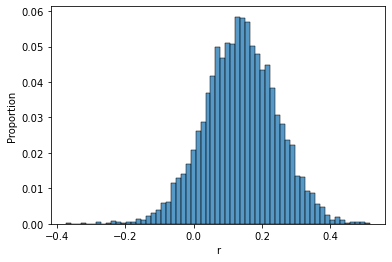

In [10]:
print('plotting', nosc_corr_controlled.r.size, 'of', nosc_corr_controlled.r.size)
sns.histplot(data=nosc_corr_controlled, x='r', stat='proportion')
plt.show()

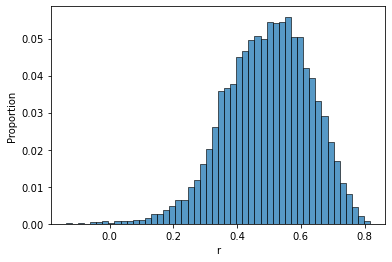

In [11]:
sns.histplot(data=nosc_corr, x='r', stat='proportion')
plt.show()

In [12]:
ex1 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/GB_GCA_018662075.nosc.csv', index_col=0)
ex2 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/RS_GCF_000518785.nosc.csv', index_col=0)
ex3 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/GB_GCA_019112785.nosc.csv', index_col=0)

In [13]:
# Fit each genome to a pair of Gaussians, one for transmembrane proteins 
# and one for non-transmembrane proteins
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


means [-0.32366889 -0.14575932]
vars [0.00379902 0.00428112]
weights [0.13929197 0.86070803]
means [-0.30096069 -0.12870317]
vars [0.00214883 0.00227533]
weights [0.12783473 0.87216527]
means [-0.32305082 -0.15277817]
vars [0.00251116 0.00273827]
weights [0.11970583 0.88029417]


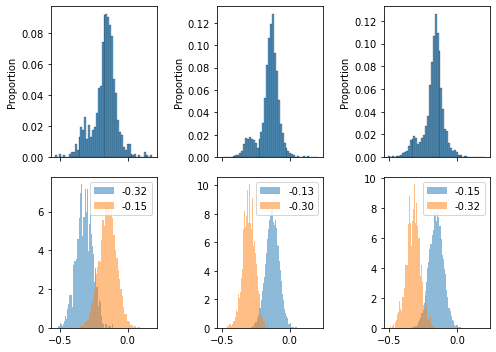

In [14]:
fig, axs = plt.subplots(figsize=(7, 5), ncols=3, nrows=2, sharex='col')

for i, my_df in enumerate([ex1, ex2, ex3]):
    plt.sca(axs[0,i])
    gmm = BayesianGaussianMixture(n_components=2)
    vals = my_df.NOSC.values.reshape(-1, 1)
    gmm.fit(vals)

    xs, labels = gmm.sample(10000)

    component_means = gmm.means_.flatten()
    idxs = np.argsort(component_means)
    component_means = component_means[idxs]
    component_vars = gmm.covariances_.flatten()[idxs]
    component_weights = gmm.weights_.flatten()[idxs]
    print('means', component_means)
    print('vars', component_vars)
    print('weights', component_weights)
    sns.histplot(data=my_df, x='NOSC', stat='proportion', bins=50)

    plt.sca(axs[1,i])
    plt.hist(xs[labels==0], bins=50, density=True, alpha=0.5,
             label='{0:.2f}'.format(gmm.means_[0][0]))
    plt.hist(xs[labels==1], bins=50, density=True, alpha=0.5,
             label='{0:.2f}'.format(gmm.means_[1][0]))
    plt.legend()

plt.tight_layout()
plt.savefig('../output/coding_sequences_dist_ex.png', dpi=300, facecolor='white')
plt.show()

In [15]:
bac120_nosc_df.shape

(62291, 122)

In [16]:
reps_genome_nosc_df.genome_avg_NOSC.notnull().sum()

62291

In [17]:
def bootstrap_mean_ci(vals, n=1000, ci=99, subsample_size=0.9):
    """Calculate the mean and confidence interval of a set of values using bootstrapping.

    Args:
        vals (array-like): The values to calculate the mean and confidence interval of.
        n (int, optional): The number of bootstrap samples to take. Defaults to 1000.
        ci (int, optional): The confidence interval to calculate in percent units. Defaults to 99%.
        subsample_size (float, optional): The fraction of the values to use in each bootstrap sample. Defaults to 0.9.
        
    Returns:
        tuple: The mean and confidence interval of the values.
    """
    # Create an array to store the bootstrap sample means
    bootstrap_means = np.zeros(n)
    size = int(len(vals) * subsample_size)

    # Perform bootstrapping
    for i in range(n):
        # Sample with replacement from the values
        bootstrap_sample = np.random.choice(vals, size=size, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the mean of the bootstrap sample means
    mean = np.mean(bootstrap_means)

    # Calculate the confidence interval (percentile method)
    ci_mass = (100 - ci) / 2
    confidence_interval = np.percentile(bootstrap_means, [ci_mass, 100-ci_mass])

    return mean, confidence_interval

In [18]:
vals = nosc_corr_controlled.r.values
bootstrap_mean_ci(vals)

np.percentile(vals, [25, 75])

array([0.06793312, 0.20992836])

In [19]:
vals = nosc_corr.r.values

bootstrap_mean_ci(vals)

np.percentile(vals, [25, 75])

array([0.40625775, 0.59193439])

In [20]:
bac120_meta_df.COG.value_counts()
cog_df

,color,description
category,,
J,FCCCFC,"Translation, ribosomal structure and biogenesis"
A,FCDCFC,RNA processing and modification
K,FCDCEC,Transcription
L,FCDCDC,"Replication, recombination and repair"
B,FCDCCC,Chromatin structure and dynamics
D,FCFCDC,"Cell cycle control, cell division, chromosome ..."
Y,FCFCCC,Nuclear structure
V,FCFCBC,Defense mechanisms
T,FCFCAC,Signal transduction mechanisms
